<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Мой-ненужный-велосипед" data-toc-modified-id="Мой-ненужный-велосипед-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Мой ненужный велосипед</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

*Нам нужно*:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

**Описание данных**

Данные лежат в файле `taxi.csv`


Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

## Подготовка

Для начала импортируем библтотеки

In [1]:
# импорты из стандартной библиотеки
import re
import warnings
import time

# импорты сторонних библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# импорты модулей текущего проекта
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    TimeSeriesSplit,
    train_test_split,
    cross_val_score,
    GridSearchCV
)
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from tqdm import trange

# настройки
warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(11.7,8.27)})

# константы заглавными буквами
RANDOM_STATE = 12345

In [2]:
# при импорте сразу столбец datetime передадим индексу
try:
    taxi = pd.read_csv('taxi.csv', 
                       index_col=[0], 
                       parse_dates=[0])
except:
    taxi = pd.read_csv('/datasets/taxi.csv', 
                       index_col=[0], 
                       parse_dates=[0])

In [3]:
# как выглядит датасет
taxi.sample(5)

,num_orders
datetime,
2018-08-22 03:20:00,29
2018-06-16 14:30:00,20
2018-06-01 15:30:00,5
2018-08-08 09:10:00,11
2018-07-06 23:20:00,17


In [4]:
# общая информация о датасете
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# общая информация о датасете
taxi.describe(include='all')

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


В датасете всего один столбец (второй стал datetime индексом), явных проблем в нем не видно

In [6]:
# на всякий проверим расположены ли данные в правильном порядке
taxi.index.is_monotonic

True

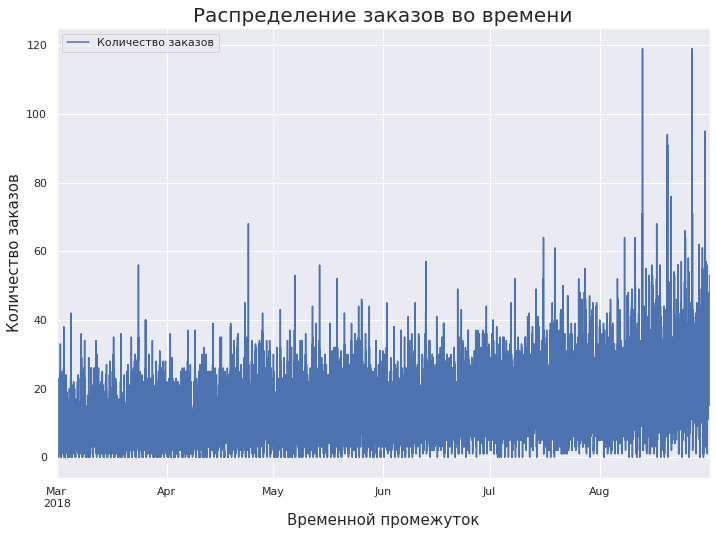

In [7]:
# посмотрим на распределение
taxi.plot()

# сделаем график читаемым
plt.title('Распределение заказов во времени', size=20)
plt.xlabel('Временной промежуток', size=15)
plt.ylabel('Количество заказов', size=15)
plt.legend(['Количество заказов'])

Проведем ресемплирование временного ряда по одному часу, для этого применим метод `resample` к нашему датафрейму.


т.к. нам нужно будет предсказывать количество заказов в час, к методу `resample` применим еще и метод `sum` для подсчета заказов.

In [8]:
taxi = taxi.resample('1H').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Итого у нас есть временной ряд с марта по август 2018 года

**`Промежуточный вывод`:**

- данные загружены и изучены
- проведена проверка на монотонность
- построен график распределения заказов во времени
- проведено ресемплирование временного ряда по одному часу

## Анализ

Попробуем посмотреть на распределение после ресемплирования

Для удобства объявим функцию для отрисовки графиков

In [10]:
def make_plot(data, title, legend=['Количество заказов']):
    
    # строим график
    data.plot()

    # делаем график читаемым
    plt.title(title, size=20)
    plt.xlabel('Временной промежуток', size=15)
    plt.ylabel('Количество заказов', size=15)
    plt.legend(legend)

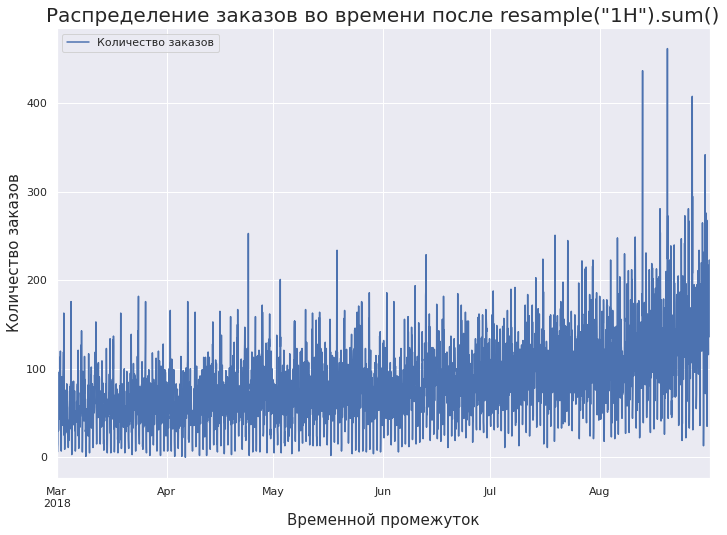

In [11]:
make_plot(data=taxi, title='Распределение заказов во времени после resample("1H").sum()')

Лучше точно не стало, посмотрим поближе.

Попробуем добавить фичей в датасет, объявим функцию `make_features`. В качестве календарных признаков возьмем  hour, day, dayofweek т.к. year и month нам тут не понадобятся (данных мало)

In [12]:
def make_features(data: pd.DataFrame, feature: str, max_lag: int, rolling_mean_size: int) -> pd.DataFrame:
    """Функция добавляет в датасет data календарные признаки, отстающие признаки и скользящее среднее

    Args:
        data (pd.DataFrame): датасет с datetime индексом
        feature (str): название признака для которого будут подсчитаны метрики
        max_lag (int): количество признаков с отстающими значениями
        rolling_mean_size (int): размер окна скользящего среднего
    Returns:
        pd.Dataframe: возвращает копию датасета с добавленными фичами
    """
    # создаем копию датасета
    data_with_features = data.copy()
    
    # добавляем календарные признаки
    data_with_features['hour'] = data.index.hour
    data_with_features['day'] = data.index.day
    data_with_features['dayofweek'] = data.index.dayofweek
    
    # добавляем отстающие признаки
    for lag in range(1, max_lag + 1):
        data_with_features['lag_{}'.format(lag)] = data[feature].shift(lag)

    # добавляем скользящее среднее
    data_with_features['rolling_mean'] = data[feature].shift().rolling(rolling_mean_size).mean()
    
    # возвращаем копию датасета
    return data_with_features

In [13]:
# попробуем указать случайные параметры
taxi_with_features = make_features(taxi, 'num_orders', 150, 150)

# сразу же дропнем NaN значения
taxi_with_features.dropna(inplace=True)

taxi_with_features.head(10)

,num_orders,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_142,lag_143,lag_144,lag_145,lag_146,lag_147,lag_148,lag_149,lag_150,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-07 06:00:00,19,6,7,2,10.0,73.0,66.0,24.0,121.0,100.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,53.753333
2018-03-07 07:00:00,17,7,7,2,19.0,10.0,73.0,66.0,24.0,121.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,53.053333
2018-03-07 08:00:00,38,8,7,2,17.0,19.0,10.0,73.0,66.0,24.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,52.600000
2018-03-07 09:00:00,50,9,7,2,38.0,17.0,19.0,10.0,73.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,52.380000
2018-03-07 10:00:00,34,10,7,2,50.0,38.0,17.0,19.0,10.0,73.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,52.273333
2018-03-07 11:00:00,58,11,7,2,34.0,50.0,38.0,17.0,19.0,10.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,52.213333
2018-03-07 12:00:00,34,12,7,2,58.0,34.0,50.0,38.0,17.0,19.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,52.560000
2018-03-07 13:00:00,55,13,7,2,34.0,58.0,34.0,50.0,38.0,17.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,52.706667
2018-03-07 14:00:00,43,14,7,2,55.0,34.0,58.0,34.0,50.0,38.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,52.973333


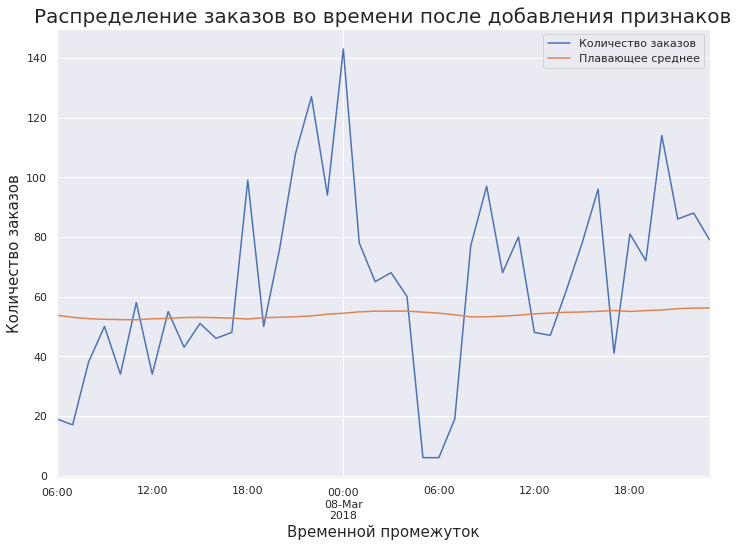

In [14]:
make_plot(data=taxi_with_features[['num_orders', 'rolling_mean']]['2018-03-01':'2018-03-08'], 
          title='Распределение заказов во времени после добавления признаков',
          legend=['Количество заказов', 'Плавающее среднее'])

Можем заметить *сезонность*. Ближе к 00:00 - 01:00 заказов становится *заметно больше*, затем все также быстро *возвращается на свои места*. Но, проверим это проведя декомпозицию ряда.

Проведем сезонную декомпозицию ряда по часам и построим графики тренда и сезонности.

In [15]:
# создадим объект DecomposeResult
decomposed = seasonal_decompose(taxi)

# и вытащим из него нужные нам атрибуты
decomposed.trend
decomposed.seasonal
decomposed.resid

datetime
2018-03-01 00:00:00   NaN
2018-03-01 01:00:00   NaN
2018-03-01 02:00:00   NaN
2018-03-01 03:00:00   NaN
2018-03-01 04:00:00   NaN
                       ..
2018-08-31 19:00:00   NaN
2018-08-31 20:00:00   NaN
2018-08-31 21:00:00   NaN
2018-08-31 22:00:00   NaN
2018-08-31 23:00:00   NaN
Freq: H, Name: resid, Length: 4416, dtype: float64

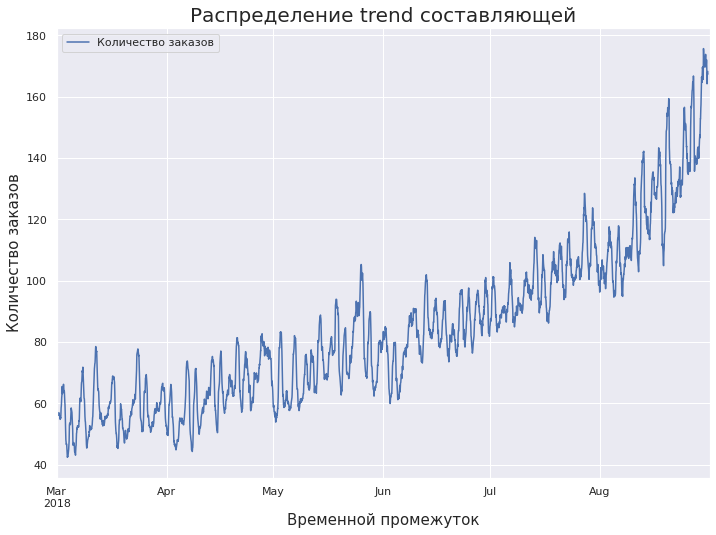

In [16]:
make_plot(data=decomposed.trend, title='Распределение trend составляющей')

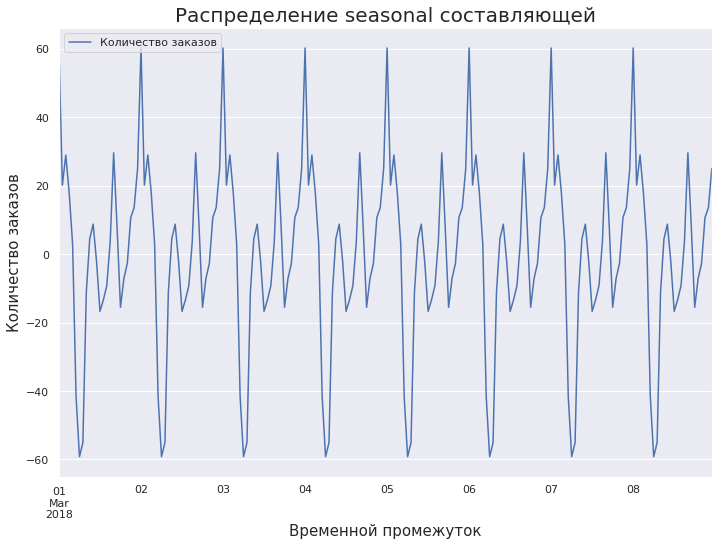

In [17]:
make_plot(data=decomposed.seasonal['2018-03-01':'2018-03-08'], 
          title='Распределение seasonal составляющей')

**`Промежуточный вывод`:**

- построен график распределения после ресемплинга
- объявлена функция make_features() для добавления новый фичей в временной ряд
- построен график распределения после добавления новый фичей в временной ряд
- проведена сезонная декомпозиция ряда по часам и построены графики тренда и сезонности
- **trend составляющая показала *постепенное увеличение количества с марта по август***
- **seasonal составляющая показала двенвую сезонность. Ближе к 00:00 - 01:00 заказов становится *заметно больше*, затем все также быстро *возвращается на свои места***

## Обучение

### Мой ненужный велосипед

Попробуем провести эксперимент с подбором фичей, а именно, какие параметры max_lag и rolling_mean_size передавать в функцию make_features, чтобы создать доп фичи перед обучением моделей. 

In [18]:
def search_features(data: pd.DataFrame, 
                    feature: str, 
                    max_lag: int, 
                    rolling_mean_size: int):
    """Функция перебирает параметры max_lag и rolling_mean_size и выводит значение RMSE на экран

    Args:
        data (pd.DataFrame): датасет с datetime индексом
        feature (str): название признака для которого будут подсчитаны метрики
        max_lag (int): количество признаков с отстающими значениями
        rolling_mean_size (int): размер окна скользящего среднего
        X_train (pd.DataFrame): трейн выборка для подсчета метрики
        y_train (pd.DataFrame): трейн выборка для подсчета метрики
        X_test (pd.DataFrame): тест выборка для подсчета метрики
        y_test (pd.DataFrame): тест выборка для подсчета метрики
    Returns:
        pd.Dataframe: возвращает копию датасета с добавленными фичами
    """
    # проходим вложенным циклом по параметрам max_lag и rolling_mean_size
    for lag in trange(1, max_lag + 1):
        for size in range(1, rolling_mean_size + 1):
            
            # создаем субдатафрейм с новыми фичами
            sub_df = make_features(data, feature, lag, size)
            
            # дропнем NaN значения
            sub_df.dropna(inplace=True)
            
            # проводим сплит на train и test
            train, test = train_test_split(
                sub_df, 
                shuffle=False, 
                test_size=0.1, 
                random_state=RANDOM_STATE)
            
            # подготавливаем выборки
            X_train = train.drop('num_orders', axis=1)
            y_train = train['num_orders']
            X_test = test.drop('num_orders', axis=1)
            y_test = test['num_orders']
            
            # обучаем и фиттим LinearRegression
            lr_model = LinearRegression()
            lr_model.fit(X_train, y_train)
            
            # делаем предсказания и считаем RMSE
            y_pred = lr_model.predict(X_test)
            rmse = mean_squared_error(y_test, y_pred) ** 0.5
            
            values = {}
            minimum = 500
            if rmse < minimum:
                values['max_lag'] = lag
                values['rolling_mean_size'] = size
                values['RMSE'] = rmse
            
            # выводим max_lag, rolling_mean_size и RMSE на экран
            #print(f'max_lag: {lag}, rolling_mean_size: {size}, RMSE: {rmse}')
    
    # возвращаем best score с параметрами
    return(values)

In [19]:
# для примера
search_features(taxi, 'num_orders', 10, 10)

100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


{'max_lag': 10, 'rolling_mean_size': 10, 'RMSE': 53.97581724059534}

Ненужный он потому, что RMSE будет все уменьшаться и уменьшаться, а время будет все увеличиваться и увеличиваться, а лучшим будет считаться самое большое количество всего (мы же не можем бесконечное количество фичей пинуть в датасет). Да и я не уверен что это правильный подход к делу!

Оставил это тут чтобы ты посмотрел, может может это, все-таки, применяется.

### Обучение моделей

Подготовим выборки и обучим модель для предсказания количества заказов в час.

Попробуем обучить LR, LGBMRegressor и CatBoostRegressor

In [20]:
# проводим сплит на train и test
train, test = train_test_split(taxi_with_features, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)

In [21]:
# подготавливаем выборки
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

print(X_train.shape[0], y_train.shape[0])
print(X_test.shape[0], y_test.shape[0])

3839 3839
427 427


In [22]:
# создадим специальный кросс валидатор для временных рядов
tscv = TimeSeriesSplit()

In [23]:
%%time

# инициализируем эстиматор
lr_model = LinearRegression()

# посчитаем cross val rmse
lr_cv_score = cross_val_score(lr_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=tscv)
lr_rmse = lr_cv_score.sum() / -5

# выводим метрику на экран
print(f'LR CROSS VAL RMSE: {lr_rmse:.3f}')

LR CROSS VAL RMSE: 24.035
CPU times: user 658 ms, sys: 1.55 s, total: 2.21 s
Wall time: 2.5 s


Результат получился даже неплохим, на удивление!


Пробуем теперь LGBMRegressor

In [24]:
%%time

# инициализируем эстиматор
lgbm_model = LGBMRegressor(random_state=RANDOM_STATE)

# посчитаем cross val rmse
lgbm_cv_score = cross_val_score(lgbm_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=tscv)
lgbm_rmse = lgbm_cv_score.sum() / -5

# выводим метрику на экран
print(f'LGBM CROSS VAL RMSE: {lgbm_rmse:.3f}')

LGBM CROSS VAL RMSE: 23.868
CPU times: user 30min 57s, sys: 5.98 s, total: 31min 3s
Wall time: 31min 7s


In [25]:
%%time

# инициализируем эстиматор
lgbm_model = LGBMRegressor(random_state=RANDOM_STATE)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_lgbm = {
    'learning_rate': np.arange(0.05, 0.15, 0.01),
    'n_estimators': range(90, 111, 5)
}

# инициализируем gs
gs_lgbm = GridSearchCV(
    lgbm_model, 
    param_grid=param_grid_lgbm, 
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_jobs=-1
)

# фиттим gs
gs_lgbm.fit(X_train, y_train)

print(f'LGBM REGRESSOR CROSS VAL RMSE: {gs_lgbm.best_score_ * -1:.3f}')
print(f'LGBM REGRESSOR BEST PARAMS: {gs_lgbm.best_params_}')
print('--------------------------')

LGBM REGRESSOR CROSS VAL RMSE: 23.715
LGBM REGRESSOR BEST PARAMS: {'learning_rate': 0.060000000000000005, 'n_estimators': 105}
--------------------------
CPU times: user 2h 27min 8s, sys: 27.7 s, total: 2h 27min 36s
Wall time: 2h 27min 50s


Результат еще лучше, пробуем CatBoostRegressor

In [26]:
%%time

# инициализируем эстиматор
cat_model = CatBoostRegressor(silent=True, random_state=RANDOM_STATE)

# посчитаем cross val rmse
cat_cv_score = cross_val_score(cat_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=tscv)
cat_rmse = cat_cv_score.sum() / -5

# выводим метрику на экран
print(f'CAT CROSS VAL RMSE: {cat_rmse:.3f}')

CAT CROSS VAL RMSE: 23.316
CPU times: user 2min 3s, sys: 762 ms, total: 2min 4s
Wall time: 2min 9s


**`Промежуточный вывод`:**

- в датасет были добавлены 150 lag фичей и плавающее среднее с окном 150
- объявлена функция search_features() для рассчета cv score по разным сочетаниям параметров
- протестированы модели:
    - LinearRegression - CV RMSE = 24.036
    - LGBMRegressor -  CV RMSE = 23.715
    - CatBoostRegressor -  CV RMSE = 23.316
- **лучшей моделью будем считать CatBoostRegressor**

## Тестирование

Протестируем лучшую модель на тестовой выборке

In [27]:
%%time

# инициализируем эстиматор
best_model = CatBoostRegressor(silent=True, random_state=RANDOM_STATE)

# fit predict и оценка качества
best_model.fit(X_train, y_train)
best_model_pred = best_model.predict(X_test)
best_model_rmse = mean_squared_error(y_test, best_model_pred) ** 0.5

# выводим метрику на экран
print(f'BEST MODEL RMSE: {best_model_rmse:.3f}')

BEST MODEL RMSE: 37.409
CPU times: user 33 s, sys: 101 ms, total: 33.1 s
Wall time: 34.3 s


Визуализируем финальные предсказания.

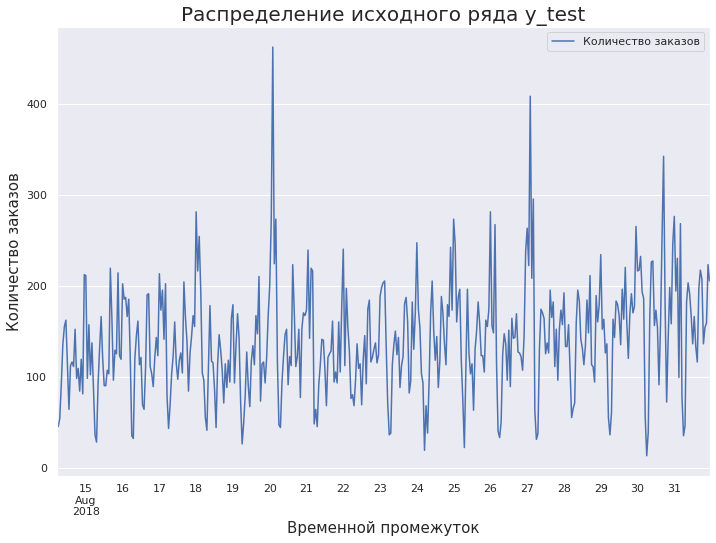

In [28]:
make_plot(data=y_test, title='Распределение исходного ряда y_test')

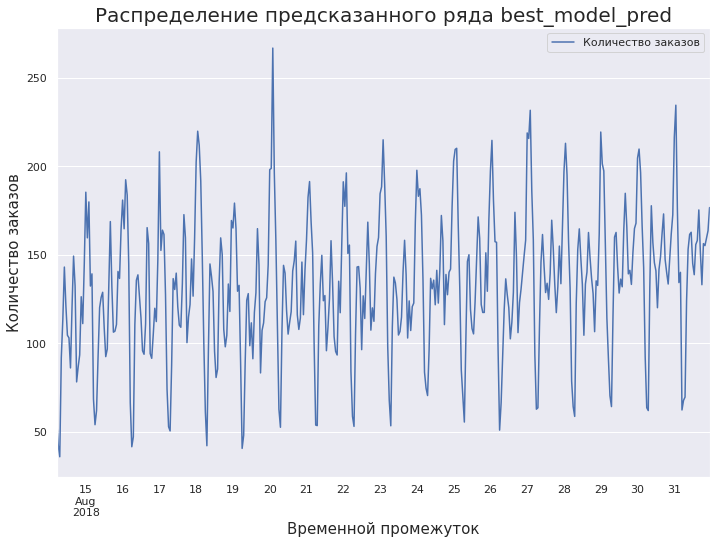

In [29]:
# превратим np.array в Series
best_model_pred = pd.Series(best_model_pred, index=y_test.index)

make_plot(data=best_model_pred, title='Распределение предсказанного ряда best_model_pred')

**`Промежуточный вывод`:**

- проведена проверка лучшей модели - BEST MODEL RMSE: 37.409
- финальные предсказания были визуализированы
- графики похожи, но в предсказанном ряде виден разброс по значениям, это подтверждает значение RMSE

## Общий вывод

**`Подготовка`:**

- данные загружены и изучены
- проведена проверка на монотонность
- построен график распределения заказов во времени
- проведено ресемплирование временного ряда по одному часу


**`Анализ`:**

- построен график распределения после ресемплинга
- объявлена функция make_features() для добавления новый фичей в временной ряд
- построен график распределения после добавления новый фичей в временной ряд
- проведена сезонная декомпозиция ряда по часам и построены графики тренда и сезонности
- **trend составляющая показала *постепенное увеличение количества с марта по август***
- **seasonal составляющая показала двенвую сезонность. Ближе к 00:00 - 01:00 заказов становится *заметно больше*, затем все также быстро *возвращается на свои места***


**`Обучение`:**

- в датасет были добавлены 150 lag фичей и плавающее среднее с окном 150
- объявлена функция search_features() для рассчета cv score по разным сочетаниям параметров
- протестированы модели:
    - LinearRegression - CV RMSE = 24.036
    - LGBMRegressor -  CV RMSE = 23.715
    - CatBoostRegression -  CV RMSE = 23.316
- **лучшей моделью будем считать CatBoostRegressor**


**`Тестирование`:**
- проведена проверка лучшей модели - BEST MODEL RMSE: 37.409
- финальные предсказания были визуализированы
- графики похожи, но в предсказанном ряде виден разброс по значениям, это подтверждает значение RMSE